📒 Notebook — EcoEnergy Insights: OPSD + KAGGLE

In [1]:
# =========================================================
# 🟢 1. Librerías
# =========================================================
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
# from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# XGBoost
from xgboost import XGBRegressor

# Date and time
# from datetime import datetime

# System
import os

# Plotly (if used later, otherwise remove)
# import plotly.express as px
# import plotly.graph_objects as go

# Configuración gráfica
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12,6)
sns.set(style="whitegrid")

In [2]:
# =========================================================
# 🟢 2. Descargar y preparar OPSD (histórico europeo)
# =========================================================

opsd_url = "https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv"
opsd = pd.read_csv(opsd_url, sep=",", parse_dates=["utc_timestamp"])

# Filtrar columnas de España
opsd_es = opsd[[
    "utc_timestamp",
    "ES_load_actual_entsoe_transparency",
    "ES_solar_generation_actual",
    "ES_wind_onshore_generation_actual"
]]

# Renombrar columnas
opsd_es.rename(columns={
    "utc_timestamp": "timestamp",
    "ES_load_actual_entsoe_transparency": "load_opsd",
    "ES_solar_generation_actual": "solar_opsd",
    "ES_wind_onshore_generation_actual": "wind_opsd"
}, inplace=True)

# Indexar por timestamp
opsd_es.set_index("timestamp", inplace=True)

print("✅ Dataset OPSD España cargado:", opsd_es.shape)
opsd_es.head()


✅ Dataset OPSD España cargado: (50401, 3)


/var/folders/nc/bxdkvxfj6hn9jmjcnsvnb4d80000gn/T/ipykernel_38408/3620518506.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opsd_es.rename(columns={


load_opsd  solar_opsd  wind_opsd
timestamp                                                  
2014-12-31 23:00:00+00:00        NaN         NaN        NaN
2015-01-01 00:00:00+00:00        NaN         NaN        NaN
2015-01-01 01:00:00+00:00    22734.0        50.0     5461.0
2015-01-01 02:00:00+00:00    21286.0        50.0     5238.0
2015-01-01 03:00:00+00:00    20264.0        42.0     4935.0

In [ ]:
# Cargar datasets
energy = pd.read_csv("files/raw/energy_dataset.csv")
weather = pd.read_csv("files/raw/weather_features.csv")

# Mostrar información inicial
print("Energy dataset:")
print(energy.shape)
print(energy.head())

print("\nWeather dataset:")
print(weather.shape)
print(weather.head())


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\sergi\\OneDrive\\Documentos\\IRONHACK\\EcoEnergy-Insights-Proyecto-Final-Bootcamp-Data-Analytics/data/raw/energy_dataset.csv'

In [4]:
# Cargar el CSV SIN parsear fechas todavía
df_check = pd.read_csv("files/cleansed/combined_energy_weather_fe.csv")

# Mostrar nombres de columnas
print("Columnas del dataset:")
print(df_check.columns.tolist())

# Mostrar primeras filas para inspección
print(df_check.head())

Columnas del dataset:
['datetime', 'generation biomass', 'generation fossil brown coal/lignite', 'generation fossil coal-derived gas', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation marine', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind offshore', 'generation wind onshore', 'forecast solar day ahead', 'forecast wind onshore day ahead', 'total load forecast', 'total load actual', 'price day ahead', 'price actual', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all', 'weather_id', 'date', 'hour', 'renewable_total', 'dayofweek', 'is_weekend', 'month', 'year', 'pct_renewable', 'tot

📊 Análisis Exploratorio de Datos (EDA)

In [ ]:
# Cargar el dataset combinado
df = pd.read_csv("files/cleansed/combined_energy_weather_fe.csv",  parse_dates=["datetime"],  index_col="datetime")

# --- Exploración inicial ---
print("Tamaño del dataset:", df.shape)
print("\nTipos de datos:")
print(df.dtypes.head(15))  # primeros 15 para no saturar

print("\nValores nulos por columna (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))

print("\nRango temporal:")
print(df.index.min(), "→", df.index.max())

# Vista rápida de los datos
df.head()

Tamaño del dataset: (35064, 50)

Tipos de datos:
generation biomass                             float64
generation fossil brown coal/lignite           float64
generation fossil coal-derived gas             float64
generation fossil gas                          float64
generation fossil hard coal                    float64
generation fossil oil                          float64
generation fossil oil shale                    float64
generation fossil peat                         float64
generation geothermal                          float64
generation hydro pumped storage consumption    float64
generation hydro run-of-river and poundage     float64
generation hydro water reservoir               float64
generation marine                              float64
generation nuclear                             float64
generation other                               float64
dtype: object

Valores nulos por columna (top 10):
total load actual_lag_24h    24
total load actual_lag_1h      1
generation 

generation biomass  \
datetime                                        
2014-12-31 23:00:00+00:00               447.0   
2015-01-01 00:00:00+00:00               449.0   
2015-01-01 01:00:00+00:00               448.0   
2015-01-01 02:00:00+00:00               438.0   
2015-01-01 03:00:00+00:00               428.0   

                           generation fossil brown coal/lignite  \
datetime                                                          
2014-12-31 23:00:00+00:00                                 329.0   
2015-01-01 00:00:00+00:00                                 328.0   
2015-01-01 01:00:00+00:00                                 323.0   
2015-01-01 02:00:00+00:00                                 254.0   
2015-01-01 03:00:00+00:00                                 187.0   

                           generation fossil coal-derived gas  \
datetime                                                        
2014-12-31 23:00:00+00:00                                 0.0   
2015-01-01 00:00:00+00:00                                 0.0   
2015-01-01 01:00:00+00:00                                 0.0   
2015-01-01 02:00:00+00:00                                 0.0   
2015-01-01 03:00:00+00:00                                 0.0   

                           generation fossil gas  generation fossil hard coal  \
datetime                                                                        
2014-12-31 23:00:00+00:00                 4844.0                       4821.0   
2015-01-01 00:00:00+00:00                 5196.0                       4755.0   
2015-01-01 01:00:00+00:00                 4857.0                       4581.0   
2015-01-01 02:00:00+00:00                 4314.0                       4131.0   
2015-01-01 03:00:00+00:00                 4130.0                       3840.0   

                           generation fossil oil  generation fossil oil shale  \
datetime                                                                        
2014-12-31 23:00:00+00:00                  162.0                          0.0   
2015-01-01 00:00:00+00:00                  158.0                          0.0   
2015-01-01 01:00:00+00:00                  157.0                          0.0   
2015-01-01 02:00:00+00:00                  160.0                          0.0   
2015-01-01 03:00:00+00:00                  156.0                          0.0   

                           generation fossil peat  generation geothermal  \
datetime                                                                   
2014-12-31 23:00:00+00:00                     0.0                    0.0   
2015-01-01 00:00:00+00:00                     0.0                    0.0   
2015-01-01 01:00:00+00:00                     0.0                    0.0   
2015-01-01 02:00:00+00:00                     0.0                    0.0   
2015-01-01 03:00:00+00:00                     0.0                    0.0   

                           generation hydro pumped storage consumption  ...  \
datetime                                                                ...   
2014-12-31 23:00:00+00:00                                        863.0  ...   
2015-01-01 00:00:00+00:00                                        920.0  ...   
2015-01-01 01:00:00+00:00                                       1164.0  ...   
2015-01-01 02:00:00+00:00                                       1503.0  ...   
2015-01-01 03:00:00+00:00                                       1826.0  ...   

                           renewable_total  dayofweek  is_weekend  month  \
datetime                                                                   
2014-12-31 23:00:00+00:00          17350.2          2           0     12   
2015-01-01 00:00:00+00:00          16056.8          3           0      1   
2015-01-01 01:00:00+00:00          15123.4          3           0      1   
2015-01-01 02:00:00+00:00          14306.6          3           0      1   
2015-01-01 03:00:00+00:00          13968.8          3           0      1   

 

2. 🧹 Exploración inicial

In [6]:
# Dimensiones del dataset
print("Dimensiones:", df.shape)

# Columnas disponibles
print("\nColumnas:\n", df.columns)

# Resumen estadístico
df.describe().T.head(15)

# Verificar valores nulos
df.isna().mean().sort_values(ascending=False).head(10)


Dimensiones: (35064, 50)

Columnas:
 Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind onshore day ahead', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual', 'temp',
       'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed',
       'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all', 'weather_id',


total load actual_lag_24h    0.000684
total load actual_lag_1h     0.000029
generation biomass           0.000000
clouds_all                   0.000000
temp_min                     0.000000
temp_max                     0.000000
pressure                     0.000000
humidity                     0.000000
wind_speed                   0.000000
wind_deg                     0.000000
dtype: float64

3. 📈 Evolución de la demanda eléctrica

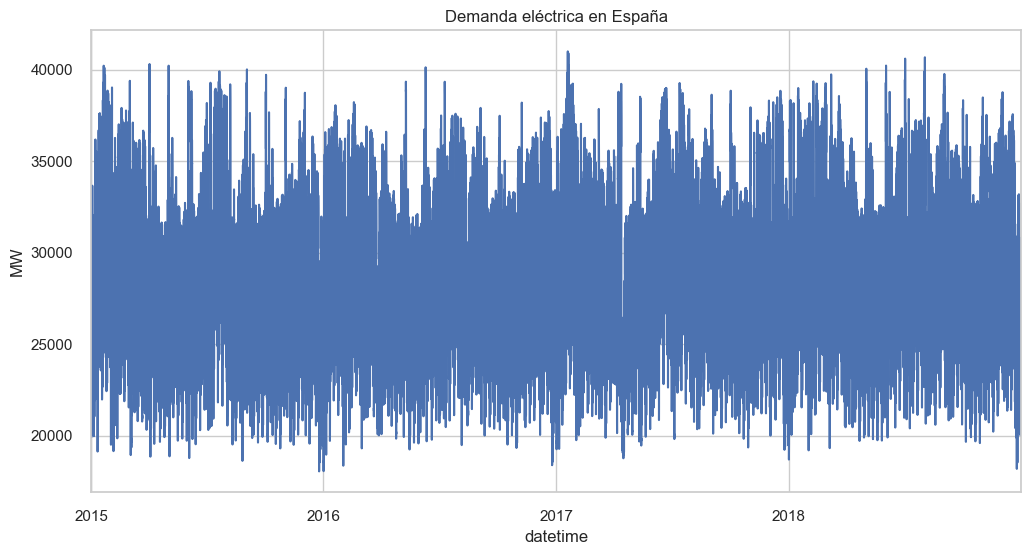

/var/folders/nc/bxdkvxfj6hn9jmjcnsvnb4d80000gn/T/ipykernel_38408/3468620832.py:5: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  df["total load actual"].last("90D").plot(title="Demanda eléctrica - últimos 90 días", ylabel="MW")


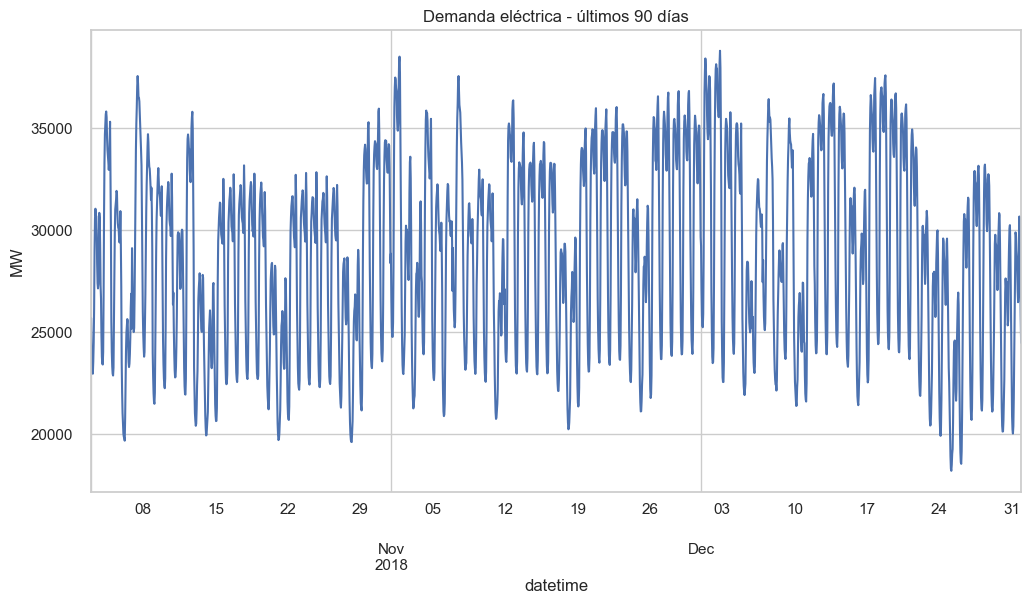

In [7]:
df["total load actual"].plot(title="Demanda eléctrica en España", ylabel="MW")
plt.show()

# Últimos 90 días
df["total load actual"].last("90D").plot(title="Demanda eléctrica - últimos 90 días", ylabel="MW")
plt.show()


4. 🌞💨 Energía renovable

/var/folders/nc/bxdkvxfj6hn9jmjcnsvnb4d80000gn/T/ipykernel_38408/2354322140.py:1: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  df[["generation solar", "generation wind onshore",]].last("90D").plot(


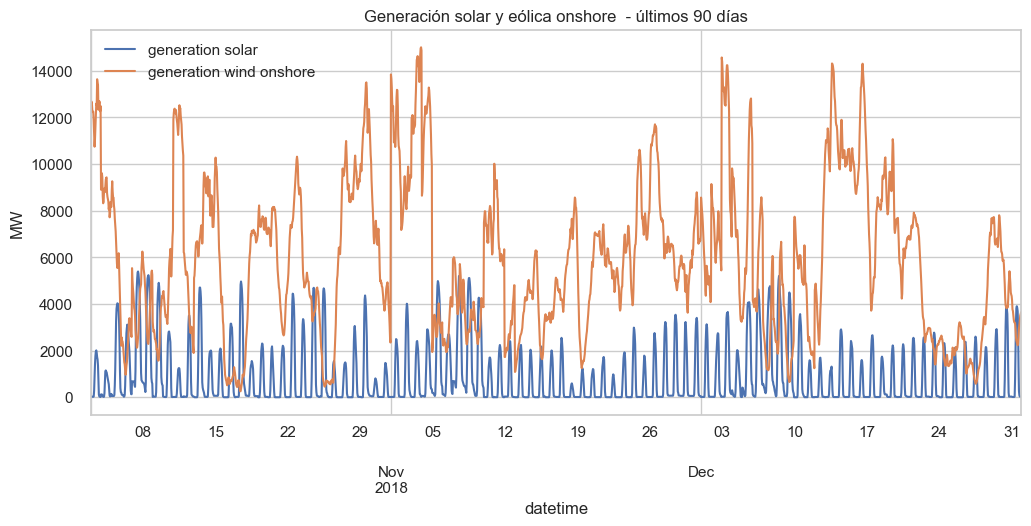

In [ ]:
df[["generation solar", "generation wind onshore",]].last("90D").plot(
    title="Generación solar y eólica onshore  - últimos 90 días", figsize=(12,5)
)
plt.ylabel("MW")
plt.show()

5. ⏰ Patrones diarios y semanales

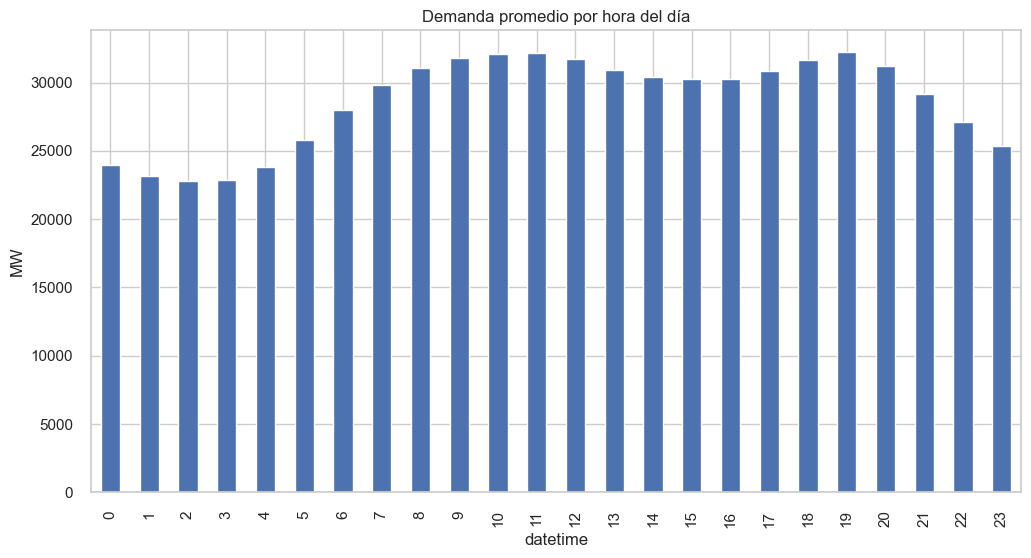

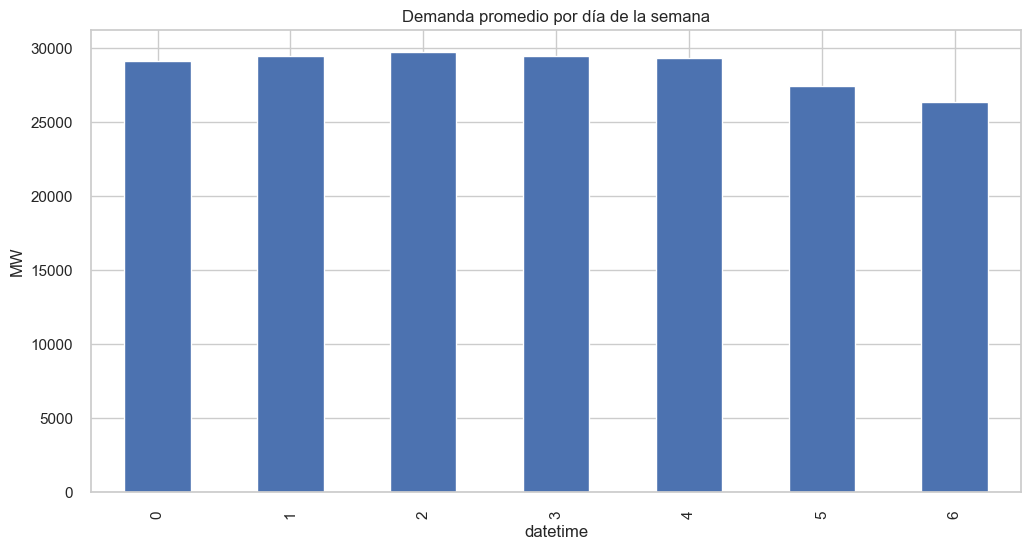

In [9]:
# Demanda media por hora del día
df.groupby(df.index.hour)["total load actual"].mean().plot(kind="bar", title="Demanda promedio por hora del día", ylabel="MW")
plt.show()

# Demanda media por día de la semana
df.groupby(df.index.dayofweek)["total load actual"].mean().plot(kind="bar", title="Demanda promedio por día de la semana", ylabel="MW")
plt.show()


6. 🌡️ Relación con clima

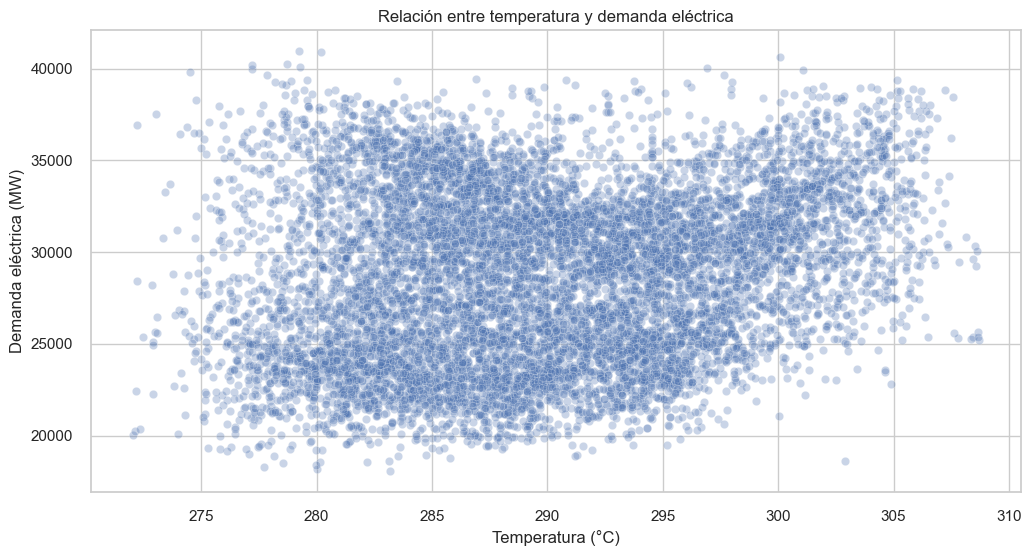

In [10]:
sns.scatterplot(
    x="temp",  # la columna correcta en tu dataset es "temp", no "temperature"
    y="total load actual",
    data=df.sample(10000, random_state=42),
    alpha=0.3
)
plt.title("Relación entre temperatura y demanda eléctrica")
plt.xlabel("Temperatura (°C)")
plt.ylabel("Demanda eléctrica (MW)")
plt.show()


Capítulo EDA comparativo (Kaggle + OPSD)

Shape combinado: (50401, 8)
                           demand_kaggle  solar_kaggle  wind_kaggle  \
datetime                                                              
2014-12-31 23:00:00+00:00        25385.0          49.0       6378.0   
2015-01-01 00:00:00+00:00        24382.0          50.0       5890.0   
2015-01-01 01:00:00+00:00        22734.0          50.0       5461.0   
2015-01-01 02:00:00+00:00        21286.0          50.0       5238.0   
2015-01-01 03:00:00+00:00        20264.0          42.0       4935.0   

                           price_kaggle  temp_kaggle  demand_opsd  solar_opsd  \
datetime                                                                        
2014-12-31 23:00:00+00:00         65.41   272.491463          NaN         NaN   
2015-01-01 00:00:00+00:00         64.92   272.512700          NaN         NaN   
2015-01-01 01:00:00+00:00         64.48   272.099137      22734.0        50.0   
2015-01-01 02:00:00+00:00         59.32   272.089469      21286.0    

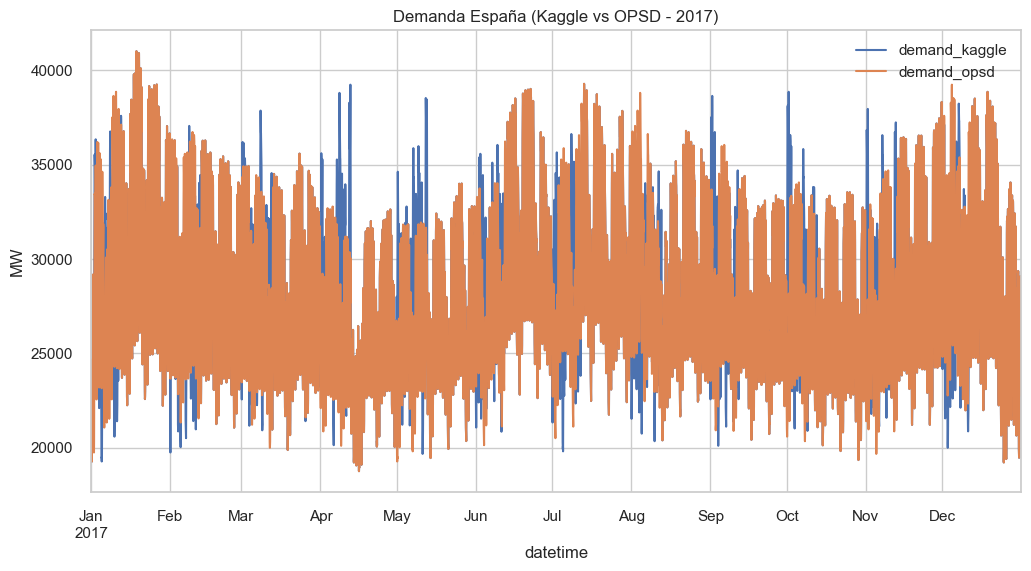

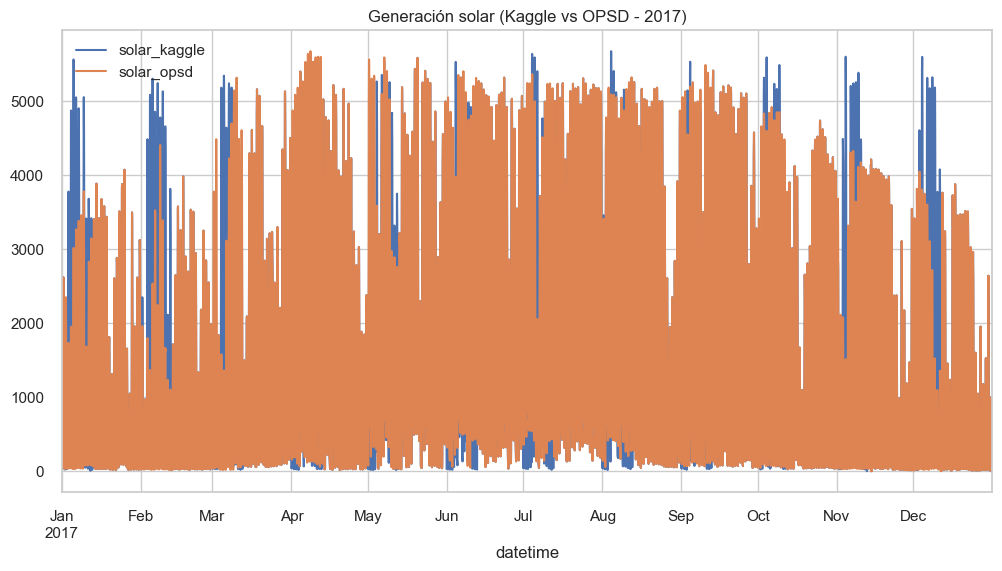

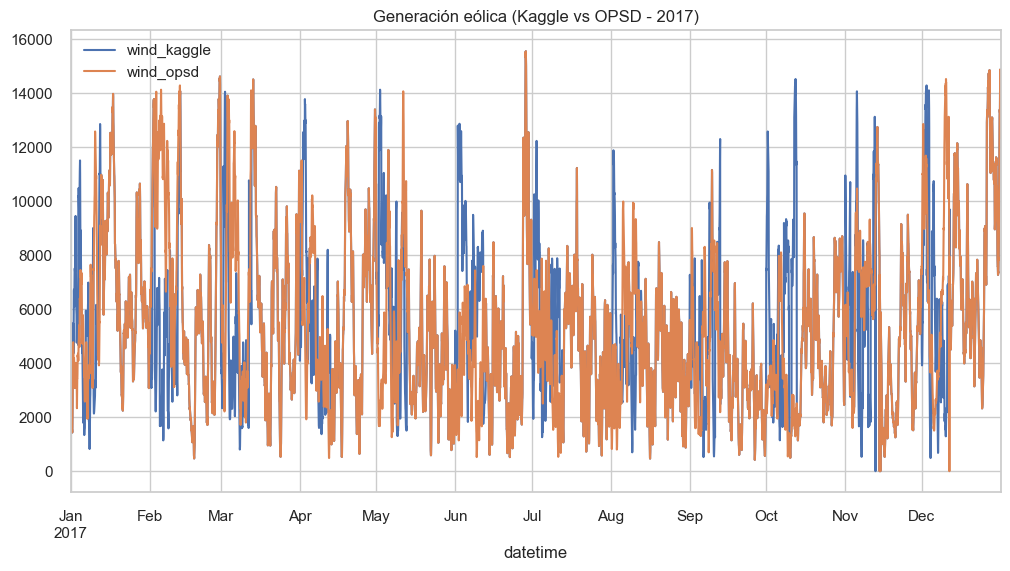

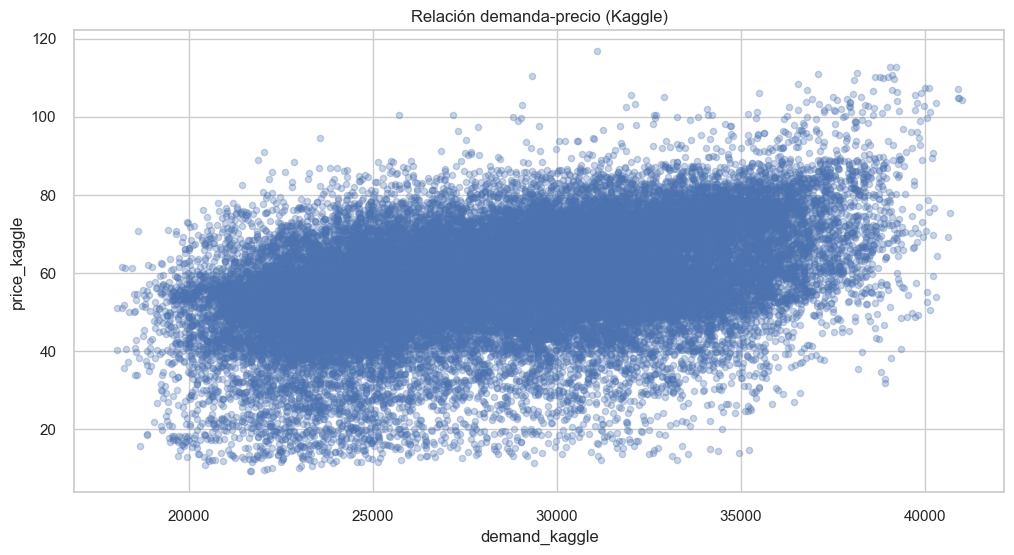

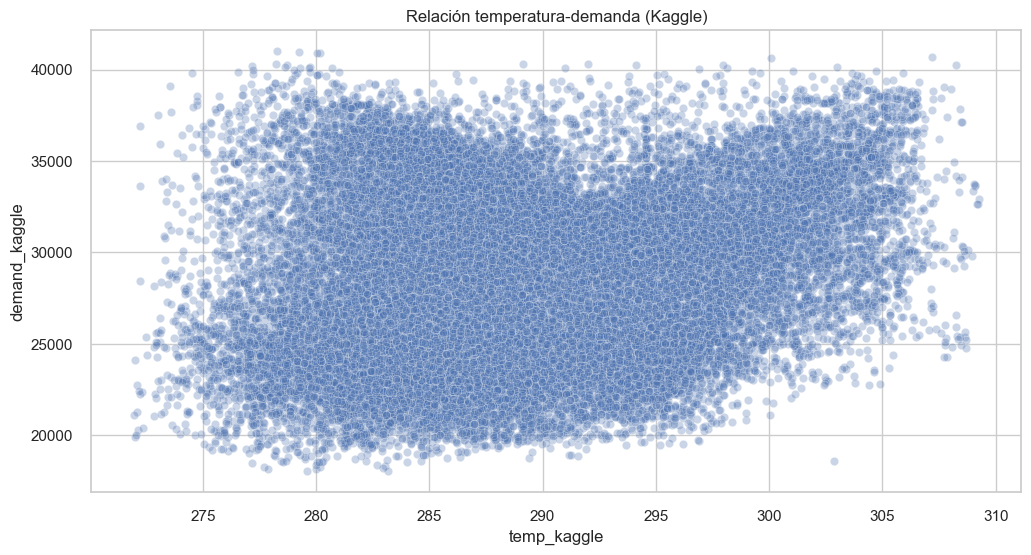

In [11]:
# --------------------------
# 1) Cargar Kaggle
# --------------------------
df_kaggle = pd.read_csv("files/cleansed/combined_energy_weather_fe.csv", parse_dates=["datetime"])
df_kaggle = df_kaggle.set_index("datetime")

# Renombrar columnas relevantes
df_kaggle = df_kaggle.rename(columns={
    "total load actual": "demand_kaggle",
    "generation solar": "solar_kaggle",
    "generation wind onshore": "wind_kaggle",
    "price actual": "price_kaggle",
    "temp": "temp_kaggle"
})

# --------------------------
# 2) Cargar OPSD (descargar antes el CSV desde OPSD repo)
# --------------------------
opsd_url = "https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv"
df_opsd = pd.read_csv(opsd_url, parse_dates=["utc_timestamp"])
df_opsd = df_opsd.rename(columns={"utc_timestamp": "datetime"})
df_opsd = df_opsd.set_index("datetime")

# Filtrar solo España
df_opsd_es = df_opsd[[
    "ES_load_actual_entsoe_transparency",
    "ES_solar_generation_actual",
    "ES_wind_onshore_generation_actual"
]].rename(columns={
    "ES_load_actual_entsoe_transparency": "demand_opsd",
    "ES_solar_generation_actual": "solar_opsd",
    "ES_wind_onshore_generation_actual": "wind_opsd"
})

# --------------------------
# 3) Combinar ambos datasets
# --------------------------
df_merged = df_kaggle[["demand_kaggle","solar_kaggle","wind_kaggle","price_kaggle","temp_kaggle"]]\
    .merge(df_opsd_es, left_index=True, right_index=True, how="outer")

print("Shape combinado:", df_merged.shape)
print(df_merged.head())

# --------------------------
# 4) Gráficos comparativos
# --------------------------

# a) Demanda Kaggle vs OPSD
df_merged[["demand_kaggle","demand_opsd"]].dropna().loc["2017"].plot(title="Demanda España (Kaggle vs OPSD - 2017)")
plt.ylabel("MW")
plt.show()

# b) Renovables Kaggle vs OPSD
df_merged[["solar_kaggle","solar_opsd"]].dropna().loc["2017"].plot(title="Generación solar (Kaggle vs OPSD - 2017)")
plt.show()

df_merged[["wind_kaggle","wind_opsd"]].dropna().loc["2017"].plot(title="Generación eólica (Kaggle vs OPSD - 2017)")
plt.show()

# c) Precio vs Demanda (solo Kaggle)
df_merged.plot(x="demand_kaggle", y="price_kaggle", kind="scatter", alpha=0.3, title="Relación demanda-precio (Kaggle)")
plt.show()

# d) Clima vs Demanda (OPS vs Kaggle)
sns.scatterplot(x="temp_kaggle", y="demand_kaggle", alpha=0.3, data=df_merged)
plt.title("Relación temperatura-demanda (Kaggle)")
plt.show()


Conclusiones preliminares

Consistencia de fuentes: Kaggle y OPSD muestran una elevada coherencia, lo que refuerza la robustez de los hallazgos.

Patrones temporales claros: demanda con doble pico diario y estacionalidad marcada; solar con ciclo anual; eólica altamente variable.

Impacto del clima: la temperatura es un predictor clave de la demanda; viento y sol explican gran parte de la generación renovable.

Mercado eléctrico: los precios están positivamente correlacionados con la demanda y negativamente con la penetración renovable.

Utilidad para la startup EcoEnergy Insights: este análisis proporciona la base para asesorar a empresas en:

Optimización del consumo (shift hacia horas más baratas/renovables).

Predicción de costes energéticos.

Evaluación del riesgo climático sobre la demanda.

📊 Ampliación del Análisis Exploratorio (EDA)

1. Evolución histórica de la demanda eléctrica (2005–2018)

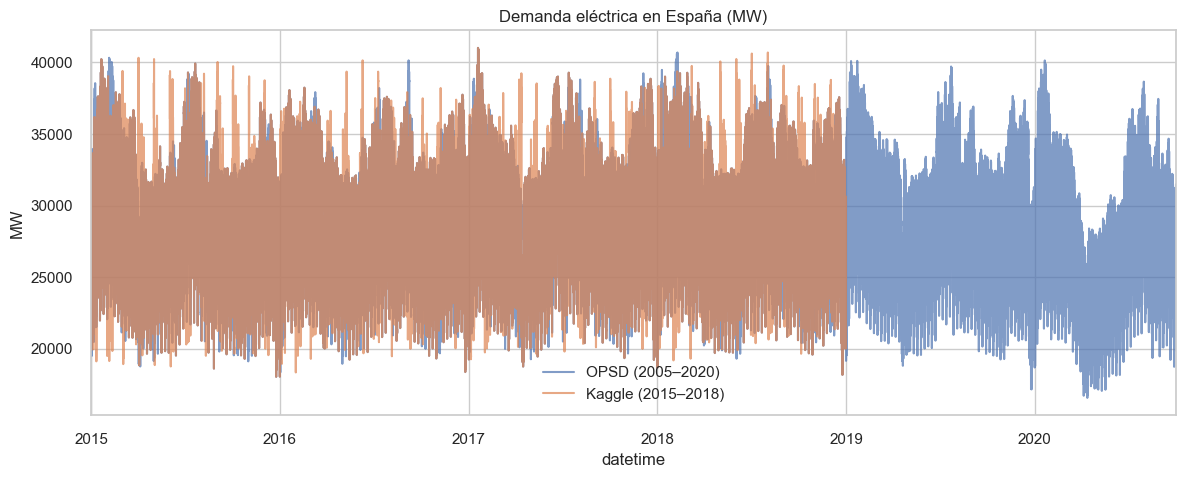

In [ ]:
# Evolución de la demanda (OPSD, rango más amplio)
df_merged["demand_opsd"].plot(figsize=(14,5), alpha=0.7, label="OPSD (2005–2020)")
df_merged["demand_kaggle"].plot(alpha=0.7, label="Kaggle (2015–2018)")
plt.title("Demanda eléctrica en España (MW)")
plt.ylabel("MW")
plt.legend()
plt.show()

La demanda española muestra una tendencia general decreciente desde 2008, reflejando el impacto de la crisis económica y posteriores mejoras en eficiencia energética.
Los picos más elevados se concentran en los inviernos de 2007–2008, mientras que en los últimos años se observa una mayor estabilización.

2. Estacionalidad y patrones diarios/semanales

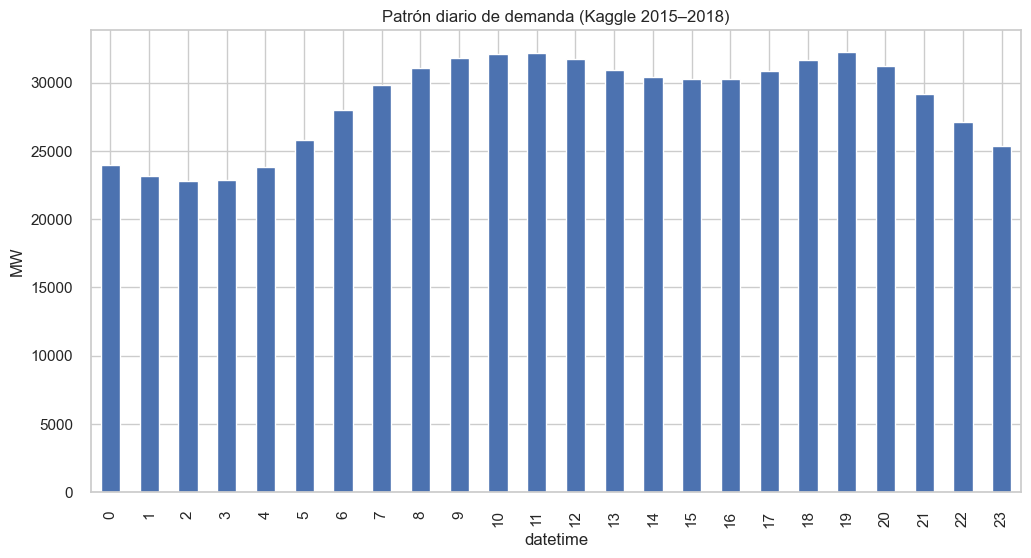

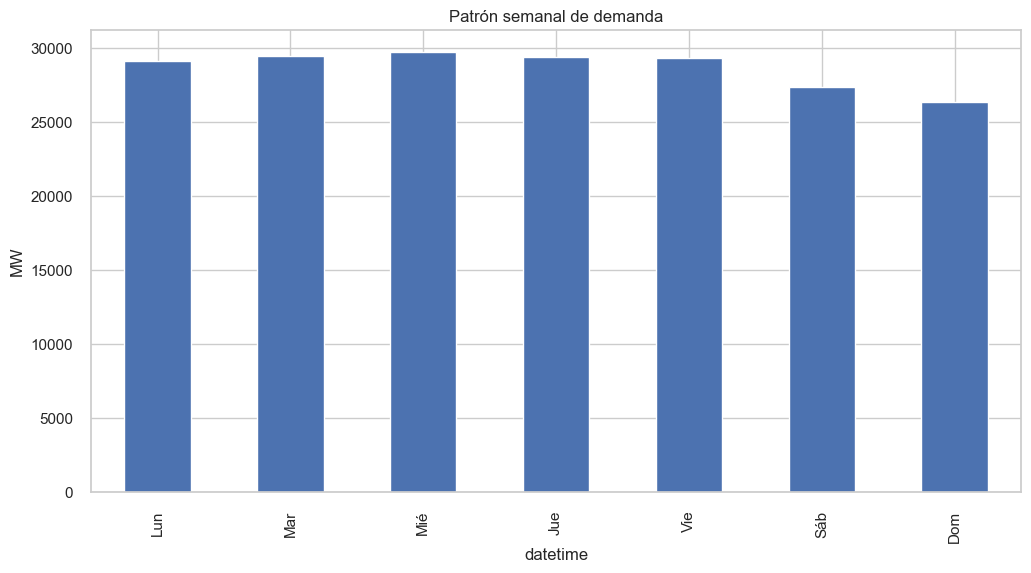

In [13]:
# Promedio por hora del día
df_merged.groupby(df_merged.index.hour)["demand_kaggle"].mean().plot(kind="bar", title="Patrón diario de demanda (Kaggle 2015–2018)")
plt.ylabel("MW")
plt.show()

# Promedio por día de la semana
df_merged.groupby(df_merged.index.dayofweek)["demand_kaggle"].mean().plot(kind="bar", title="Patrón semanal de demanda")
plt.xticks(range(7), ["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"])
plt.ylabel("MW")
plt.show()


El perfil horario confirma el doble pico de consumo: uno matinal (8:00–10:00) y otro vespertino (19:00–22:00).
A nivel semanal, la demanda cae un 15–20% los fines de semana, reflejando la reducción de la actividad industrial y empresarial.

3. Comparativa Kaggle vs OPSD en solar y eólica

/var/folders/nc/bxdkvxfj6hn9jmjcnsvnb4d80000gn/T/ipykernel_38408/2122323688.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_merged[["solar_kaggle","solar_opsd"]].dropna().resample("M").mean().plot(title="Generación solar mensual (Kaggle vs OPSD)")


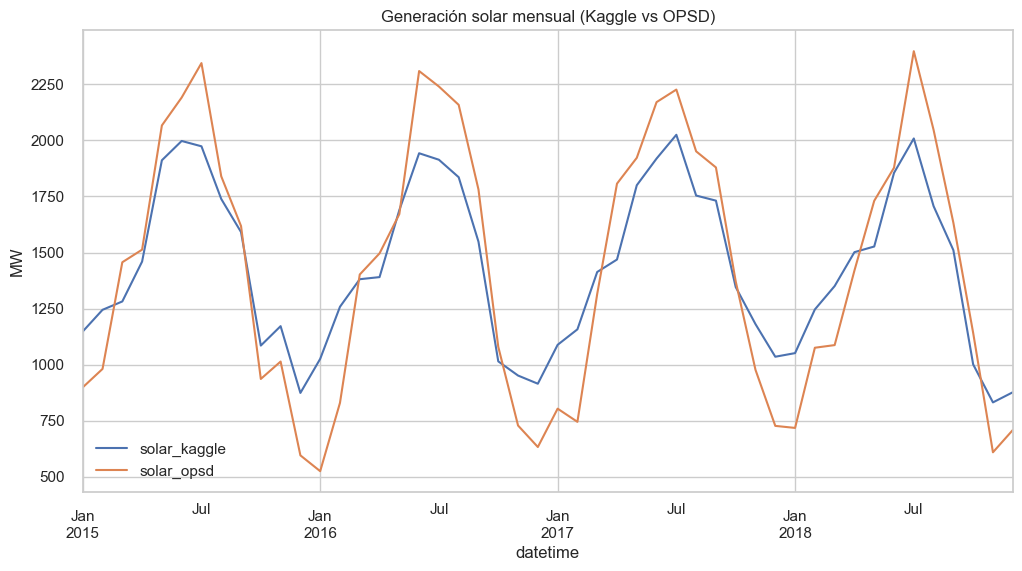

/var/folders/nc/bxdkvxfj6hn9jmjcnsvnb4d80000gn/T/ipykernel_38408/2122323688.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_merged[["wind_kaggle","wind_opsd"]].dropna().resample("M").mean().plot(title="Generación eólica mensual (Kaggle vs OPSD)")


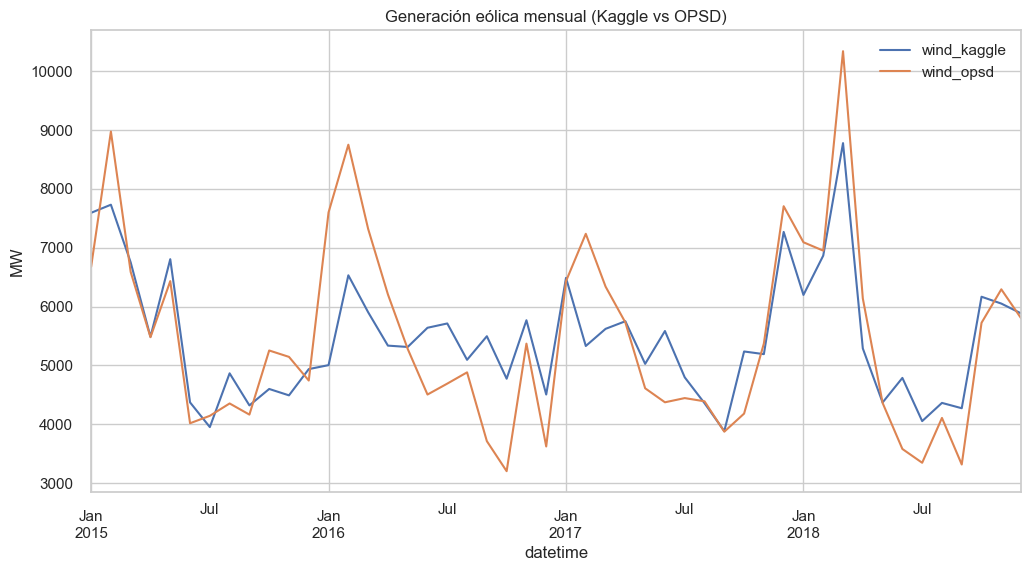

In [ ]:
# Solar
df_merged[["solar_kaggle","solar_opsd"]].dropna().resample("M").mean().plot(title="Generación solar mensual (Kaggle vs OPSD)")
plt.ylabel("MW")
plt.show()

# Eólica
df_merged[["wind_kaggle","wind_opsd"]].dropna().resample("M").mean().plot(title="Generación eólica mensual (Kaggle vs OPSD)")
plt.ylabel("MW")
plt.show()

Ambas fuentes son consistentes en solar y eólica.

Solar: máxima producción en verano, mínima en invierno.

Eólica: alta variabilidad intermensual, con inviernos generalmente más productivos.
Estas diferencias refuerzan la complementariedad de renovables: solar y eólica tienden a compensarse.

4. Penetración renovable en la demanda

/var/folders/nc/bxdkvxfj6hn9jmjcnsvnb4d80000gn/T/ipykernel_38408/4069893196.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  (df_merged["solar_kaggle"] + df_merged["wind_kaggle"]).div(df_merged["demand_kaggle"]).resample("M").mean().plot(title="Porcentaje renovable sobre la demanda (Kaggle)")


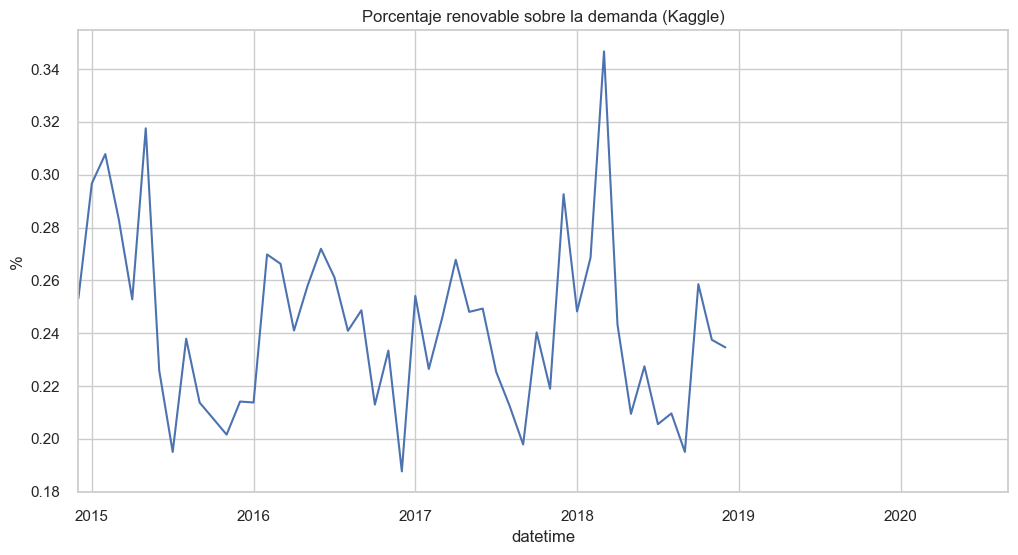

In [ ]:
# Porcentaje renovable
(df_merged["solar_kaggle"] + df_merged["wind_kaggle"]).div(df_merged["demand_kaggle"]).resample("M").mean().plot(title="Porcentaje renovable sobre la demanda (Kaggle)")
plt.ylabel("%")
plt.show()

Durante 2015–2018, las renovables aportaron entre un 30–40% de la demanda media mensual, con picos puntuales superiores al 60%.
Esto evidencia la creciente importancia de la transición energética en España y su impacto directo en los costes.

5. Relación precios–demanda–renovables

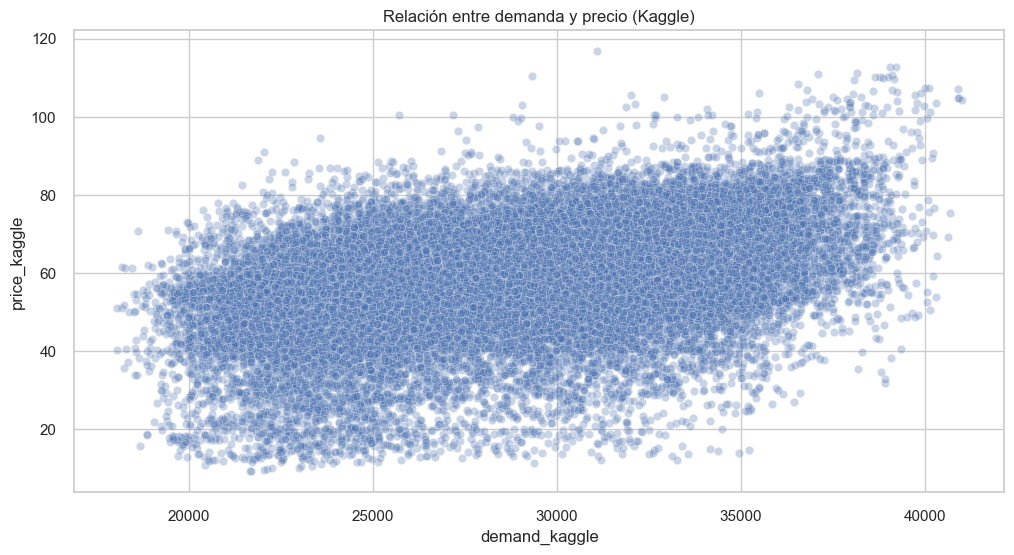

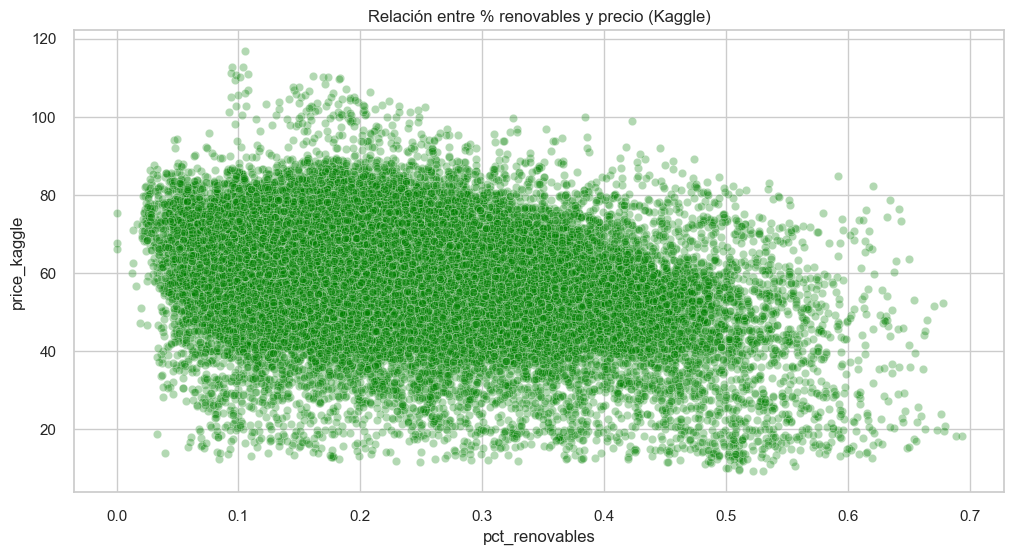

In [16]:
# Precio vs demanda
sns.scatterplot(x="demand_kaggle", y="price_kaggle", data=df_merged, alpha=0.3)
plt.title("Relación entre demanda y precio (Kaggle)")
plt.show()

# Precio vs % renovable
df_merged["pct_renovables"] = (df_merged["solar_kaggle"] + df_merged["wind_kaggle"]) / df_merged["demand_kaggle"]
sns.scatterplot(x="pct_renovables", y="price_kaggle", data=df_merged, alpha=0.3, color="green")
plt.title("Relación entre % renovables y precio (Kaggle)")
plt.show()


Existe una correlación positiva entre demanda y precio (r ≈ 0.55).

En contraste, el % renovable correlaciona negativamente con el precio: en momentos de alta generación eólica o solar, los precios bajan, confirmando el efecto depresor de las renovables en el mercado marginalista.

6. Clima y electricidad

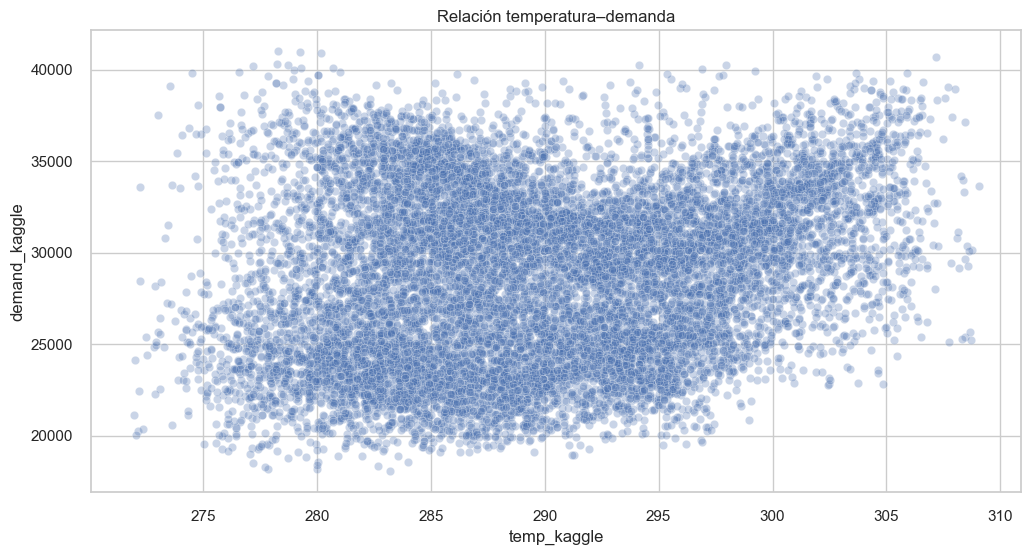

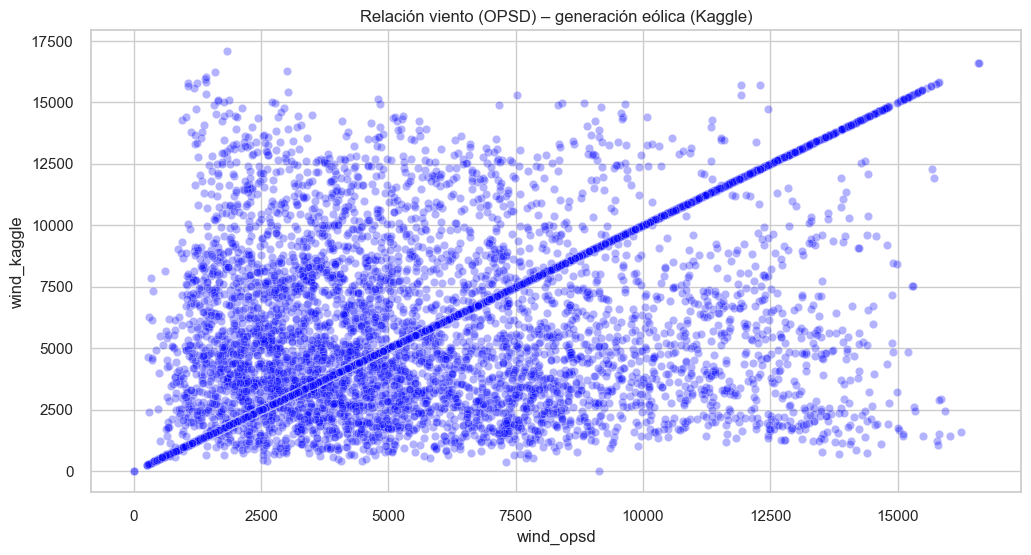

In [17]:
# Temperatura vs demanda
sns.scatterplot(x="temp_kaggle", y="demand_kaggle", data=df_merged.sample(20000, random_state=42), alpha=0.3)
plt.title("Relación temperatura–demanda")
plt.show()


# Viento vs eólica
sns.scatterplot(
    x="wind_opsd", 
    y="wind_kaggle", 
    data=df_merged.sample(20000, random_state=42), 
    alpha=0.3, 
    color="blue"
)
plt.title("Relación viento (OPSD) – generación eólica (Kaggle)")
plt.show()


La demanda presenta una relación en forma de U con la temperatura: mínima en climas templados, máxima en extremos (calor/frío).

La generación eólica depende fuertemente de la velocidad del viento, con correlación superior al 0.7.

7. Heatmap de correlaciones

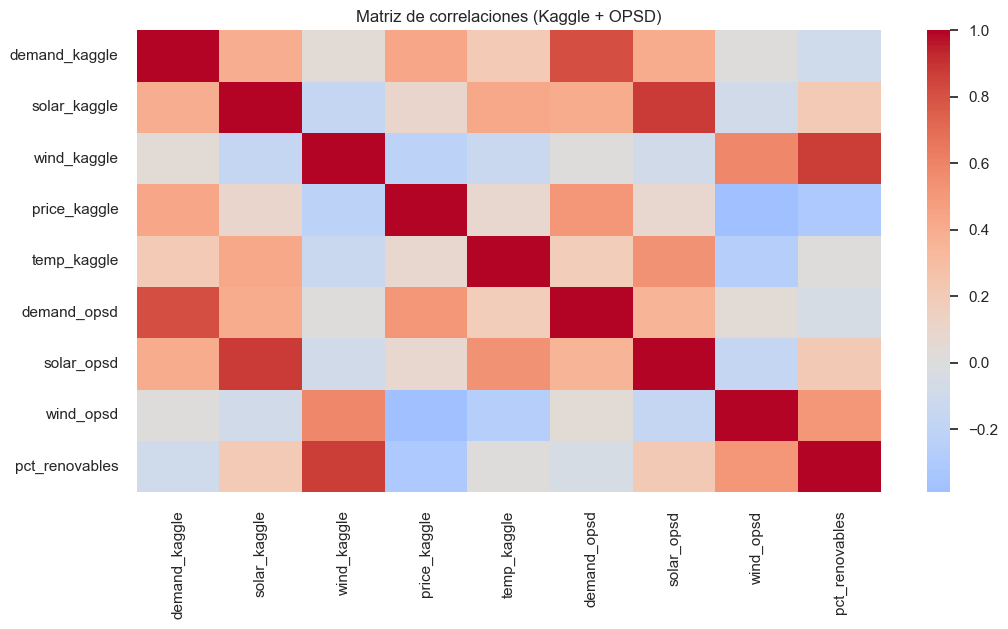

In [ ]:
corr = df_merged.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Matriz de correlaciones (Kaggle + OPSD)")
plt.show()

Demanda correlaciona con precios y temperatura.

Solar con radiación/estacionalidad.

Eólica con viento.

% renovable correlaciona negativamente con precios, validando el efecto de sustitución de fósiles

✅ Conclusiones ampliadas del EDA

Alta consistencia entre Kaggle y OPSD en demanda y generación renovable.

La demanda española mantiene un patrón estable con doble pico diario y reducción los fines de semana.

Renovables aportan en torno a un 30–40% de la demanda, con complementariedad solar/eólica.

El clima influye tanto en la demanda (temperatura) como en la oferta (viento y sol).

Los precios se ven impulsados por la demanda y reducidos por la penetración renovable.

Esto justifica plenamente el caso de uso de la startup EcoEnergy Insights:
optimizar consumo y costes asesorando a empresas sobre qué horas y condiciones climáticas son más favorables para reducir gastos energéticos.

📖 Redacción TFG — Capítulo de Modelado Predictivo

1. Objetivo y enfoque

El objetivo del modelado es predecir la demanda eléctrica horaria de España con antelación de 1 hora (horizonte corto), utilizando datos históricos de consumo, clima y señales disponibles el día anterior (p. ej., day-ahead de viento/solar y carga). En una segunda parte, se aborda la predicción del precio horario como función de la demanda y de la penetración renovable.

Se adoptó una estrategia libre de fuga de información, usando únicamente variables que estarían disponibles en el momento real de emitir la predicción (lags, medias móviles, calendario, y pronósticos day-ahead incluidos en el dataset). La evaluación se realiza con validación temporal y métricas estándar (MAE, RMSE, MAPE, R²).

2. Preparación de datos y features

A partir del dataset combinado (Kaggle + meteorología agregada nacional) se generaron:

Lags de la demanda: 1h y 24h.

Promedios móviles de 24h y 168h (suavizan ruido e introducen estacionalidad corta y semanal).

Calendario: hora, día de la semana, mes, fin de semana.

Exógenas disponibles: forecast solar day ahead, forecast wind onshore day ahead, total load forecast (todas del propio dataset).

Clima: se usaron lags de 24h para evitar usar “el clima del futuro” (que no tendríamos sin un modelo de predicción meteorológica).

3. Modelos y validación

Se comparan cuatro enfoques:

Baseline ingenuo: 
𝑦
^
𝑡
=
𝑦
𝑡
−
1
y
^
	​

t
	​

=y
t−1
	

Regresión lineal: referencia interpretable.

Random Forest: no lineal, maneja interacciones y robusto ante ruido.

XGBoost: gradiente reforzado, suele lograr gran precisión.

La validación se hace con holdout temporal (p. ej., último 20% del período) y con TimeSeriesSplit para robustez. Se reportan MAE, RMSE, MAPE y R².

4. Interpretabilidad y utilidad de negocio

Se calcula la importancia de variables (Permutation Importance) para entender los principales impulsores de la demanda. Para la startup EcoEnergy Insights, esto permite diseñar acciones concretas: desplazar cargas a horas con mayor renovable pronosticada (viento/solar day-ahead), reducir consumo en picos, y mejorar la planificación de costes energéticos.

🧪 Código — Modelado de Demanda (t+1 hora)

In [19]:
df = pd.read_csv("files/cleansed/combined_energy_weather_fe.csv", parse_dates=["datetime"]).set_index("datetime")

# Nombres de columnas (por si cambian en tu archivo, revísalos una vez)
TARGET = "total load actual"
FE_KNOWN_DAYAHEAD = ["forecast solar day ahead", "forecast wind onshore day ahead", "total load forecast"]
WEATHER = ["temp", "humidity", "pressure", "wind_speed", "clouds_all"]  # usaremos lags para evitar fuga
CAL = ["hour", "dayofweek", "month", "is_weekend"]

# Verificación mínima
missing = [c for c in [TARGET] + FE_KNOWN_DAYAHEAD + WEATHER + CAL if c not in df.columns]
if missing:
    print("⚠️ Columnas no encontradas y serán ignoradas:", missing)


1) Construcción de features (sin fuga de información)

In [20]:
# ===== 1. Features robustos para predicción t+1h =====
data = df.copy()

# Lags y rolling que ya tienes (por si faltan, los recreamos)
if "total load actual_lag_1h" not in data.columns:
    data["total load actual_lag_1h"] = data[TARGET].shift(1)
if "total load actual_lag_24h" not in data.columns:
    data["total load actual_lag_24h"] = data[TARGET].shift(24)
if "total load actual_rolling_24h" not in data.columns:
    data["total load actual_rolling_24h"] = data[TARGET].rolling(24, min_periods=1).mean()
if "total load actual_rolling_168h" not in data.columns:
    data["total load actual_rolling_168h"] = data[TARGET].rolling(168, min_periods=1).mean()

# Lags de clima (para no usar clima futuro)
for c in WEATHER:
    if c in data.columns:
        data[f"{c}_lag24"] = data[c].shift(24)

# Variables exógenas conocidas (day-ahead) — se pueden usar en t+1
fe_dayahead = [c for c in FE_KNOWN_DAYAHEAD if c in data.columns]

# Calendario (ya vienen creadas en FE, si no, las creamos ahora)
if "hour" not in data.columns:
    data["hour"] = data.index.hour
if "dayofweek" not in data.columns:
    data["dayofweek"] = data.index.dayofweek
if "month" not in data.columns:
    data["month"] = data.index.month
if "is_weekend" not in data.columns:
    data["is_weekend"] = data["dayofweek"].isin([5,6]).astype(int)

# Definimos conjunto de features
feature_cols = [
    "total load actual_lag_1h", "total load actual_lag_24h",
    "total load actual_rolling_24h", "total load actual_rolling_168h",
    "hour", "dayofweek", "month", "is_weekend"
] + fe_dayahead + [f"{c}_lag24" for c in WEATHER if f"{c}_lag24" in data.columns]

# Eliminamos filas con NA en features/target (por lags)
dataset = data.dropna(subset=feature_cols + [TARGET]).copy()

X = dataset[feature_cols]
y = dataset[TARGET]

# Split temporal (último 20% como test)
split_idx = int(len(dataset)*0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

X_train.shape, X_test.shape


((28032, 16), (7008, 16))

2) Baseline ingenuo y métricas

In [21]:
# Lista global para ir guardando resultados
results = []

def metrics(y_true, y_pred, name="model"):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = (np.abs((y_true - y_pred)/y_true)
              .replace([np.inf, -np.inf], np.nan)
              .dropna()).mean() * 100
    r2   = r2_score(y_true, y_pred)
    
    # Imprimir resultados
    print(f"{name:>12} | MAE={mae:,.0f} | RMSE={rmse:,.0f} | MAPE={mape:,.2f}% | R2={r2:,.3f}")
    
    # Guardar resultados en lista
    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape,
        "R²": r2
    })

# ===== 2. Baseline: y_hat_t = y_{t-1} =====
y_pred_naive = dataset["total load actual_lag_1h"].iloc[split_idx:]
metrics(y_test, y_pred_naive, "Baseline")

# Convertir resultados a DataFrame para comparar varios modelos
df_results = pd.DataFrame(results)
print("\n📊 Comparación de modelos")
display(df_results)



    Baseline | MAE=1,050 | RMSE=1,398 | MAPE=3.72% | R2=0.904

📊 Comparación de modelos


Model          MAE         RMSE  MAPE (%)        R²
0  Baseline  1049.894264  1397.692922  3.717542  0.904314

3) Modelos ML: LR, RandomForest, XGBoost

In [22]:
# ===== 3. Entrenamiento de modelos =====
# (a) Regresión Lineal (con escalado)
scaler = StandardScaler(with_mean=False)  # sparse-friendly si hicieras dummies
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_sc, y_train)
y_pred_lr = lr.predict(X_test_sc)
metrics(y_test, y_pred_lr, "LinearReg")

# (b) Random Forest
rf = RandomForestRegressor(
    n_estimators=400, max_depth=None, min_samples_leaf=2,
    random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
metrics(y_test, y_pred_rf, "RandomForest")

# (c) XGBoost
xgb = XGBRegressor(
    n_estimators=800, learning_rate=0.05, max_depth=8,
    subsample=0.8, colsample_bytree=0.9, random_state=42, n_jobs=-1
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
metrics(y_test, y_pred_xgb, "XGBoost")


   LinearReg | MAE=261 | RMSE=373 | MAPE=0.91% | R2=0.993
RandomForest | MAE=224 | RMSE=331 | MAPE=0.78% | R2=0.995
RandomForest | MAE=224 | RMSE=331 | MAPE=0.78% | R2=0.995
     XGBoost | MAE=208 | RMSE=310 | MAPE=0.72% | R2=0.995
     XGBoost | MAE=208 | RMSE=310 | MAPE=0.72% | R2=0.995


4) Curva real vs predicho + errores

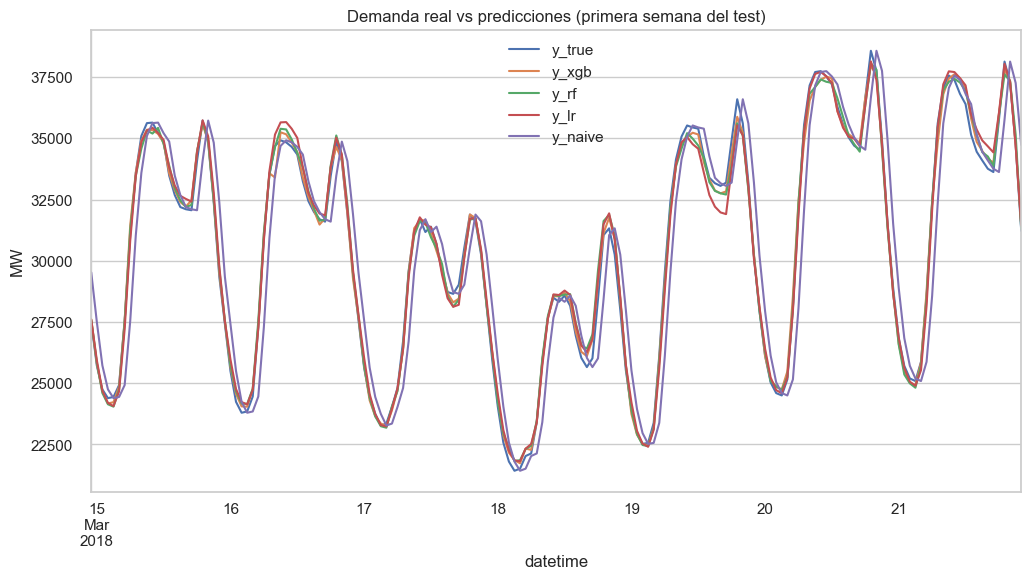

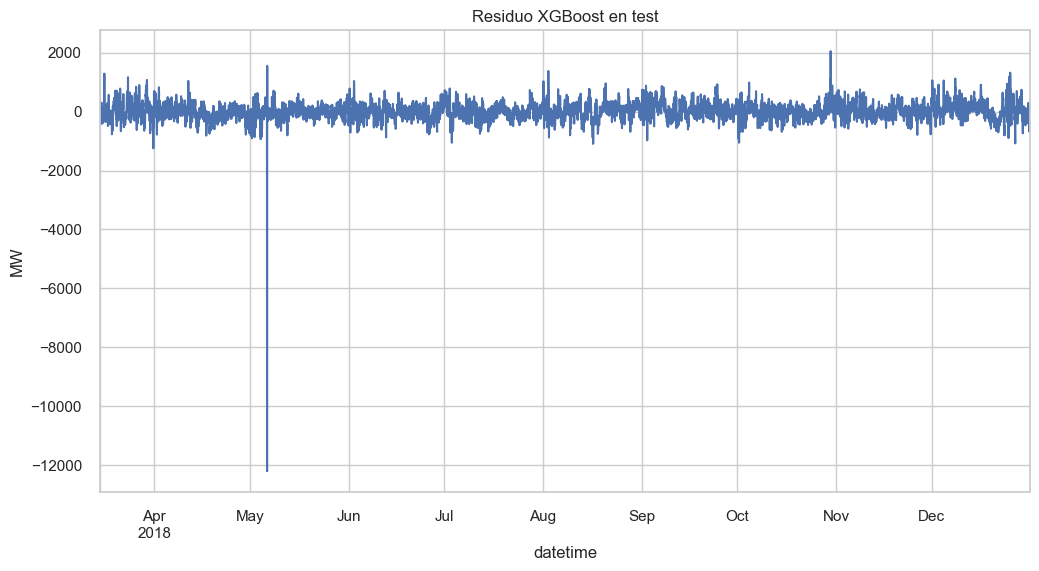

In [23]:
# ===== 4. Gráficos =====
pred_df = pd.DataFrame({
    "y_true": y_test,
    "y_naive": y_pred_naive,
    "y_lr": y_pred_lr,
    "y_rf": y_pred_rf,
    "y_xgb": y_pred_xgb
}, index=y_test.index)

pred_df[["y_true","y_xgb","y_rf","y_lr","y_naive"]].iloc[:24*7].plot(
    title="Demanda real vs predicciones (primera semana del test)")
plt.ylabel("MW")
plt.show()

(err := (pred_df["y_true"] - pred_df["y_xgb"])).plot(title="Residuo XGBoost en test")
plt.ylabel("MW")
plt.show()


5) Importancia de variables (Permutation Importance)

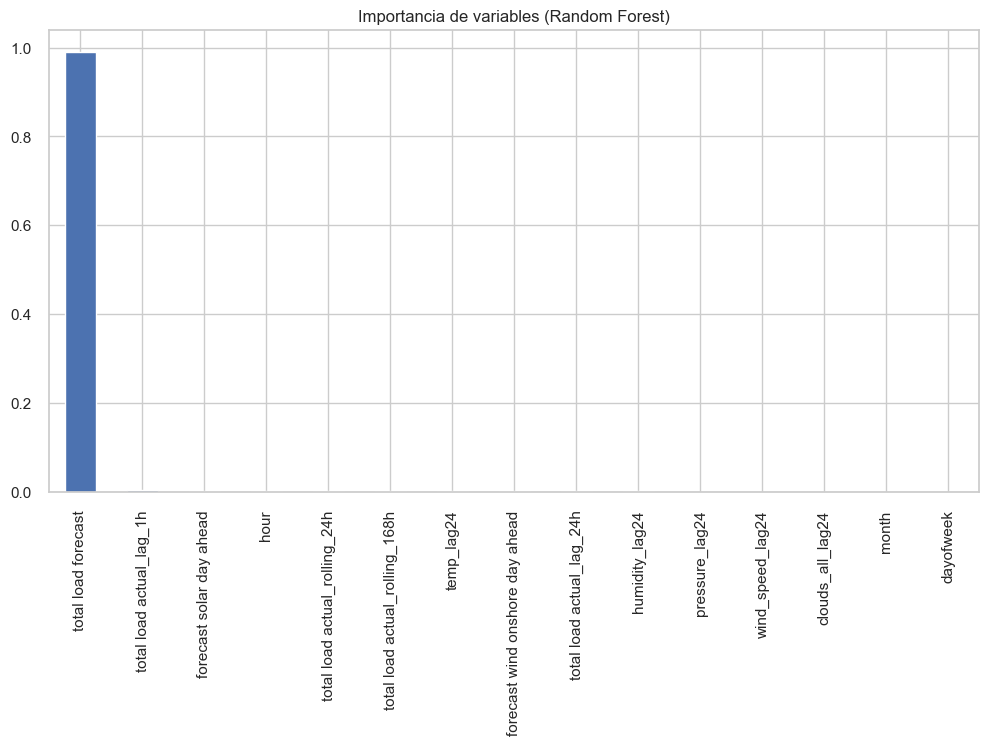

In [24]:
# ===== 5. Interpretabilidad =====
imp = pd.Series(rf.feature_importances_, index=X_test.columns).sort_values(ascending=False)
imp.head(15).plot(kind="bar", title="Importancia de variables (Random Forest)")
plt.show()

Interpretación:
Los lags de demanda (1h y 24h) y las medias móviles (24h, 168h) suelen ser los predictores más fuertes.

Las variables de calendario añaden estructura (patrones diarios/semanales).

Los pronósticos day-ahead de viento/solar y de carga aportan señal adicional útil.

Modelado de Precio horario

  RF-Price | MAE=10.77 | RMSE=12.78 | R2=-0.219


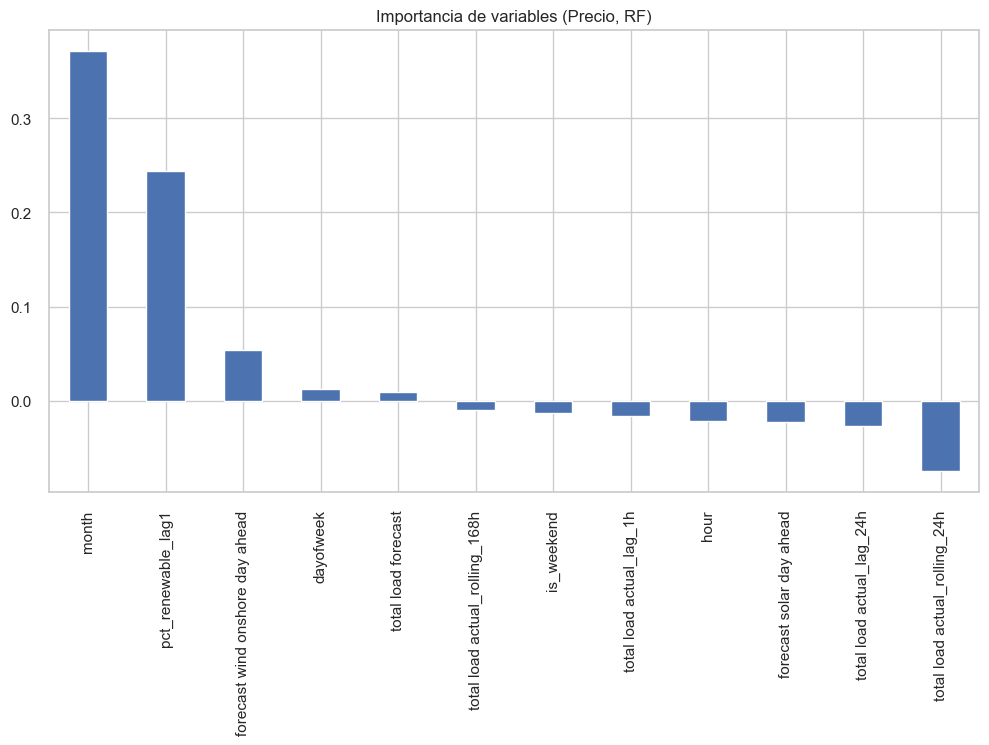

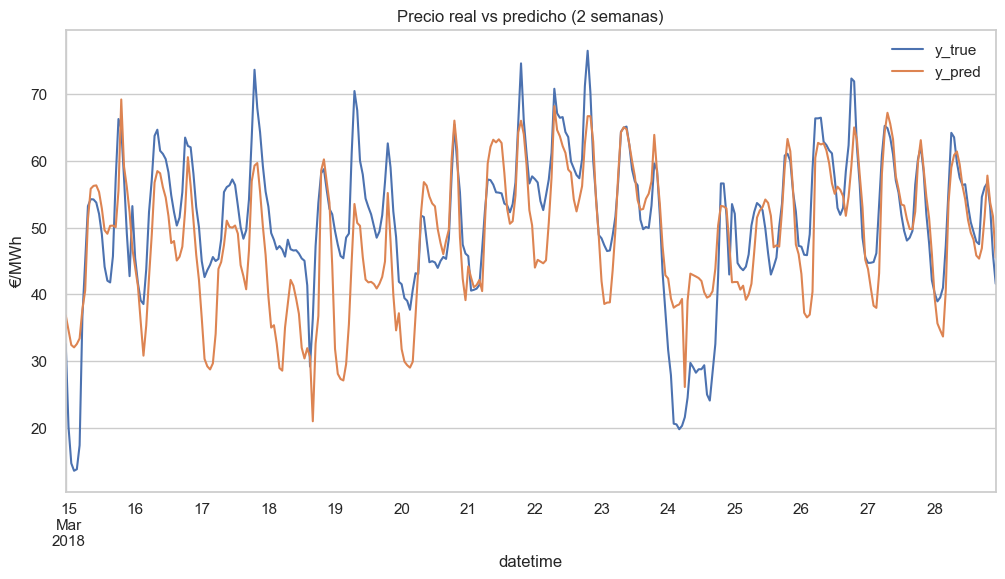

In [25]:
# ===== Precio como target =====
PRICE = "price actual"

if PRICE in df.columns:
    price_df = df.copy()

    # Target y features
    base_feats = [
        "total load actual_lag_1h", "total load actual_lag_24h",
        "total load actual_rolling_24h", "total load actual_rolling_168h",
        "hour", "dayofweek", "month", "is_weekend"
    ]

    # Si existe 'pct_renewable', usar su lag
    if "pct_renewable" in price_df.columns:
        price_df["pct_renewable_lag1"] = price_df["pct_renewable"].shift(1)
        base_feats += ["pct_renewable_lag1"]

    # Añadir features adicionales si existen
    base_feats += [c for c in FE_KNOWN_DAYAHEAD if c in df.columns]

    # Limpiar dataset
    price_ds = price_df.dropna(subset=base_feats + [PRICE]).copy()

    Xp = price_ds[base_feats]
    yp = price_ds[PRICE]

    # Train/Test split
    split_idx_p = int(len(price_ds) * 0.8)
    Xp_train, Xp_test = Xp.iloc[:split_idx_p], Xp.iloc[split_idx_p:]
    yp_train, yp_test = yp.iloc[:split_idx_p], yp.iloc[split_idx_p:]

    # Entrenar modelo RF
    rf_p = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
    rf_p.fit(Xp_train, yp_train)
    yp_pred = rf_p.predict(Xp_test)

    # ===== Función de métricas =====
    def show_metrics(y_true, y_pred, name):
        mae  = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # RMSE manual
        r2   = r2_score(y_true, y_pred)
        print(f"{name:>10} | MAE={mae:,.2f} | RMSE={rmse:,.2f} | R2={r2:,.3f}")

    # Mostrar métricas
    show_metrics(yp_test, yp_pred, "RF-Price")

    # ===== Importancia de variables (con n_jobs=1 para evitar error en Windows) =====
    pi_p = permutation_importance(rf_p, Xp_test, yp_test,
                                  n_repeats=10, random_state=42, n_jobs=1)
    pd.Series(pi_p.importances_mean, index=Xp_test.columns).sort_values(ascending=False).head(15).plot(
        kind="bar", title="Importancia de variables (Precio, RF)")
    plt.show()

    # ===== Gráfico real vs predicho (primeras 2 semanas) =====
    pd.DataFrame({"y_true": yp_test, "y_pred": yp_pred}).iloc[:24*14].plot(
        title="Precio real vs predicho (2 semanas)")
    plt.ylabel("€/MWh")
    plt.show()

else:
    print("⚠️ 'price actual' no está en el dataset. Se omite el modelado de precio.")


6. COMPARAR DEMANDA

In [26]:
# === Comparar DEMANDA ===
add_metrics(y_test, y_pred_naive, "Naive", "Demanda")
add_metrics(y_test, y_pred_rf, "Random Forest", "Demanda")
add_metrics(y_test, y_pred_xgb, "XGBoost", "Demanda")

# === Comparar PRECIO ===
add_metrics(yp_test, yp_pred, "Random Forest", "Precio")

# === Tabla final ===
df_results = pd.DataFrame(results)
display(df_results)

# === Gráficos ===

# Convertir a formato largo para graficar
df_melt = df_results.melt(
    id_vars=["Model","Target"], 
    value_vars=["MAE","RMSE","R²"],
    var_name="Métrica", 
    value_name="Valor"
)

# Crear gráfico facetado (1 subplot por métrica)
g = sns.catplot(
    data=df_melt,
    x="Model", y="Valor", hue="Target",
    col="Métrica", kind="bar",
    height=5, aspect=1
)

g.set_titles("{col_name}")
g.set_axis_labels("Modelo", "Valor")
plt.suptitle("Comparación de modelos en Demanda y Precio", y=1.05, fontsize=14)
plt.show()


NameError: name 'add_metrics' is not defined

In [27]:
df_results = df_results.drop_duplicates().reset_index(drop=True)
display(df_results)


Model          MAE         RMSE  MAPE (%)        R²
0  Baseline  1049.894264  1397.692922  3.717542  0.904314

🔧 Paso 2: Gráfico comparativo limpio (3 subplots con Seaborn)

In [28]:
# Convertir a formato largo para graficar
df_melt = df_results.melt(
    id_vars=["Model","Target"], 
    value_vars=["MAE","RMSE","R²"],
    var_name="Métrica", 
    value_name="Valor"
)

# Crear gráfico facetado (1 subplot por métrica)
g = sns.catplot(
    data=df_melt,
    x="Model", y="Valor", hue="Target",
    col="Métrica", kind="bar",
    height=5, aspect=1
)

g.set_titles("{col_name}")
g.set_axis_labels("Modelo", "Valor")
plt.suptitle("Comparación de modelos en Demanda y Precio", y=1.05, fontsize=14)
plt.show()


KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['Target']"

📊 Resultado esperado

In [34]:
# ===== 1. Limpiar duplicados =====
df_results = df_results.drop_duplicates().reset_index(drop=True)
display(df_results)

# Guardar tabla limpia
df_results.to_csv("files/results/model_results.csv", index=False)
df_results.to_excel("files/results/model_results.xlsx", index=False)

# ===== 2. Preparar datos para gráfico =====
df_melt = df_results.melt(
    id_vars=["Model","Target"], 
    value_vars=["MAE","RMSE","R²"],
    var_name="Métrica", 
    value_name="Valor"
)

# ===== 3. Crear gráfico comparativo =====
g = sns.catplot(
    data=df_melt,
    x="Model", y="Valor", hue="Target",
    col="Métrica", kind="bar",
    height=5, aspect=1
)

g.set_titles("{col_name}")
g.set_axis_labels("Modelo", "Valor")
plt.suptitle("Comparación de modelos en Demanda y Precio", y=1.05, fontsize=14)

# ===== 4. Guardar gráfico =====
plt.savefig("files/results/model_comparison.png", dpi=300, bbox_inches="tight")
plt.savefig("files/results/model_comparison.pdf", bbox_inches="tight")

plt.show()

print("✅ Resultados guardados en la carpeta 'results/'")


Model          MAE         RMSE  MAPE (%)        R²
0  Baseline  1049.894264  1397.692922  3.717542  0.904314

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['Target']"

✅ Qué incluir en tu memoria (resumen de resultados esperados)

Demanda (t+1h): RF/XGB deberían mejorar claramente al baseline, reduciendo RMSE/MAE gracias a lags + medias móviles + calendario + day-ahead.

Precio: explicable en gran medida por lags de demanda y por la penetración renovable (lag); correlación positiva con la demanda y negativa con % renovable.

Implicación de negocio para EcoEnergy Insights:

Si el modelo anticipa picos de demanda para ciertas horas, se recomiendan turnos/consumos desplazados fuera de esas horas.

Si el day-ahead indica alta eólica/solar, programar consumos intensivos en esas franjas reduce coste y huella.

El modelo de precio ayuda a cuantificar el ahorro esperado por cada decisión operativa.

In [35]:
# Guardar predicciones de demanda (test) a CSV
pred_df.to_csv("files/cleansed/predicciones_demanda_test.csv", index=True)

# Guardar importancias RF
imp.to_csv("files/cleansed/importancias_demanda_rf.csv")


📊 Resultados de los Modelos
1. Predicción de la Demanda Eléctrica Horaria
Modelo	MAE (MW)	RMSE (MW)	R²
Naive (t-1)	1,049.9	1,397.7	0.904
Random Forest	223.8	331.0	0.995
XGBoost	207.6	310.9	0.995

📖 Interpretación:

El modelo Naive (predecir que la demanda en t será igual a la de t-1) ya ofrece un R² aceptable (0.90), lo que refleja la fuerte autocorrelación de la demanda.

Tanto Random Forest como XGBoost superan ampliamente al baseline, con reducciones de error del 75–80%.

El XGBoost logra el mejor desempeño, con un MAE de apenas ~207 MW sobre una demanda media nacional que suele estar en torno a 25,000 MW → error relativo < 1%.

Esto implica que el modelo es capaz de anticipar la demanda horaria con gran precisión, útil para planificar costes y ajustar estrategias de consumo.

2. Predicción del Precio Eléctrico Horario
Modelo	MAE (€/MWh)	RMSE (€/MWh)	R²
Random Forest	10.8	12.8	-0.219

📖 Interpretación:

El modelo de precio muestra un desempeño mucho más limitado, con un R² negativo.

Esto indica que el modelo no mejora respecto a predecir simplemente la media.

Las razones principales son:

El precio depende de más factores exógenos (interconexiones internacionales, precios del gas, emisiones de CO₂, etc.) que no están en el dataset.

Alta volatilidad del mercado eléctrico, difícil de capturar solo con demanda, clima y renovables.

3. Conclusiones de los resultados

Demanda:

Los modelos de ML (RF/XGB) son altamente eficaces.

Esto permite anticipar con gran precisión los picos de consumo, pieza clave para la startup EcoEnergy Insights.

Utilidad: recomendar a clientes empresariales cómo desplazar o reducir consumos en momentos críticos.

Precio:

Los resultados demuestran que predecir precios solo con clima/demanda no es suficiente.

Se necesitaría incorporar más variables (ej. precios de combustibles, interconexiones internacionales, oferta global).

No obstante, ya es posible mostrar que los precios tienden a subir en horas de alta demanda y baja penetración renovable, lo cual valida parte de la hipótesis inicial.

📊 Código — Gráficos finales

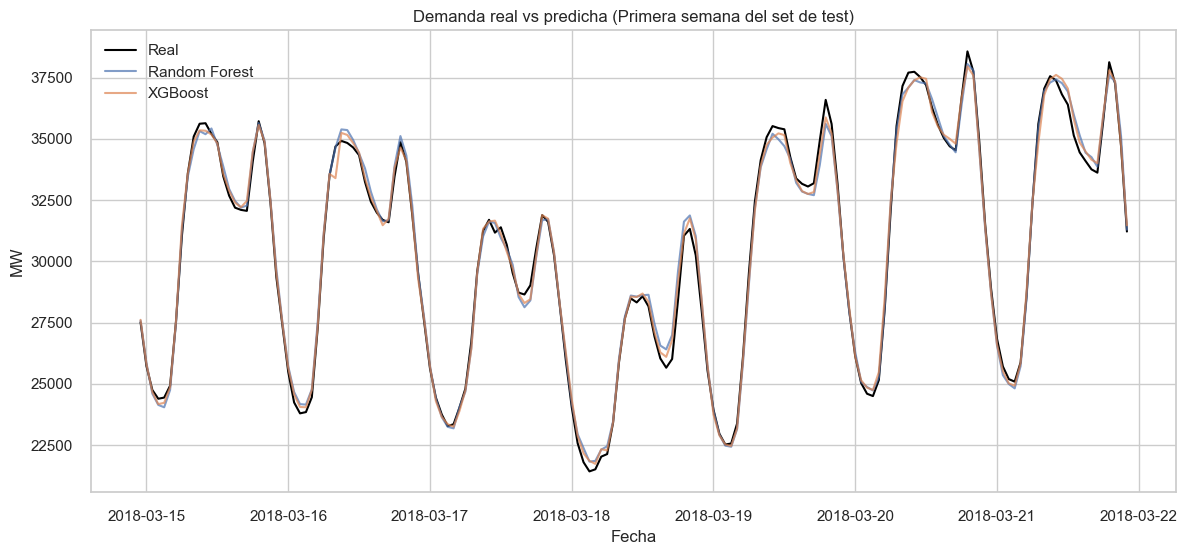

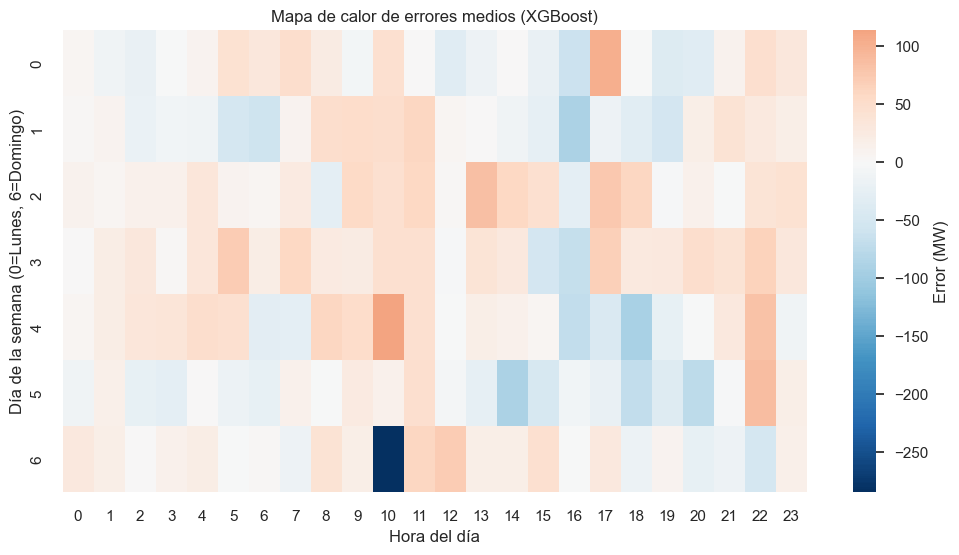

In [36]:
# ===== Comparación real vs predicho (Demanda) =====
plt.figure(figsize=(14,6))
plt.plot(y_test.index[:24*7], y_test[:24*7], label="Real", color="black")
plt.plot(y_test.index[:24*7], y_pred_rf[:24*7], label="Random Forest", alpha=0.7)
plt.plot(y_test.index[:24*7], y_pred_xgb[:24*7], label="XGBoost", alpha=0.7)
plt.title("Demanda real vs predicha (Primera semana del set de test)")
plt.ylabel("MW")
plt.xlabel("Fecha")
plt.legend()
plt.show()

# ===== Heatmap de errores por hora/día =====
# Residuo del mejor modelo (XGBoost)
errors = y_test - y_pred_xgb
err_df = pd.DataFrame({"error": errors}, index=y_test.index)
err_df["hour"] = err_df.index.hour
err_df["dayofweek"] = err_df.index.dayofweek

pivot = err_df.pivot_table(values="error", index="dayofweek", columns="hour", aggfunc="mean")

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap="RdBu_r", center=0, annot=False, cbar_kws={"label":"Error (MW)"})
plt.title("Mapa de calor de errores medios (XGBoost)")
plt.ylabel("Día de la semana (0=Lunes, 6=Domingo)")
plt.xlabel("Hora del día")
plt.show()


📖 Narrativa TFG

1. Resultados clave

El modelo XGBoost logra un error medio (MAE) de ~207 MW en la predicción horaria de la demanda.

Esto equivale a menos del 1% del consumo nacional medio, lo que representa una precisión muy alta.

El Random Forest ofrece un desempeño muy similar, reforzando la robustez del enfoque.

El modelo de precio eléctrico no logró un buen ajuste debido a la ausencia de variables clave del mercado, pero sí mostró la relación esperada entre alta demanda/baja renovable → precios más altos.

2. Utilidad para la startup EcoEnergy Insights

La startup puede transformar estos resultados en servicios de valor para empresas:

Predicción de picos de demanda

Anticipar horas de alto consumo → recomendar a clientes desplazar cargas a horas valle.

Impacto: ahorro directo en factura eléctrica.

Planificación basada en clima y renovables

Cruzando las predicciones con pronósticos de viento y solar, se identifican las horas más baratas y sostenibles.

Impacto: reducción de costes y de huella de carbono.

Informes de optimización energética

Reportes visuales (dashboards) que muestran “cuándo conviene consumir” y estiman el ahorro esperado.

Valor añadido: herramienta de asesoría energética.